## Gaussian Mixer Model

In this notebook, I implemented Guassian Mixture Model from scratch using Numpy, Scipy, Matplotlib and other Standard Python Libraries.
Clustering is an Unsupervised Learning method and GMM is a probabilistic model that comprises of Gaussians for each cluster.

In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import re
#suppress warnings
warnings.filterwarnings('ignore')

## Loading the data

In [2]:
with open('cluster.txt') as f:
    lines = f.readlines()
    
regexp = "^\d+\.\d+ \d+\.\d+ [a-zA-Z]+_?[a-zA-Z]*" # regular expression

lines = [i for i in lines if re.search(regexp, i)]  # valid lines from the text file

r = len(lines) # number_data_samples
c = 3 # number_clusters

# split the data from the original string
data = []
for i in range(len(lines)):
    data.append(lines[i].split())
class_label = []
data1 = []
data2 = []
for i in range(len(data)):
    class_label.append(data[i][2].replace('\n','')) # classes_label
    data1.append(float(data[i][0])) # feature 1
    data2.append(float(data[i][1])) # feature 2
x = np.empty((len(data), 2))
x[:,0] = data1
x[:,1] = data2
"""
r = len(x) 
c = 3
"""

classes = []
classes.append(class_label[0])
for i in class_label:
        if i not in classes:
            classes.append(i)
x_pclass = []
for i in range(r):
    if class_label[i] == "Head":
        x_pclass.append(0)
    elif class_label[i] == "Ear_left":
        x_pclass.append(1)
    elif class_label[i] == "Ear_right":
        x_pclass.append(2)
x_pclass = np.array(x_pclass)          
train_data = np.zeros((r,c))
train_data[:,0] = x[:,0] # feature 1
train_data[:,1] = x[:,1] # feature 2
train_data[:,2] = x_pclass[:] # numerical value of the class labels
count = 0
for i in range(len(train_data)):
    if train_data[i,2] == 3:
        count += 1
train_data

array([[0.45660138, 0.43280641, 0.        ],
       [0.61137847, 0.5286246 , 0.        ],
       [0.45029897, 0.71160612, 0.        ],
       ...,
       [0.81551494, 0.71351702, 2.        ],
       [0.78569142, 0.68191384, 2.        ],
       [0.70826683, 0.76123423, 2.        ]])

In [ ]:
with open('cluster.txt') as f:
    lines = f.readlines()

idx = []  
# only select the lines that have valid data
for i in range(len(lines)):
    if lines[i][1] != '#' or lines[:] == []:
        idx.append(i)

D = []        
for i in idx:
    D.append(lines[i].split()) # split the entire string to remove spaces between features and labels
class_label = [] # array of all the labels
data1 = [] # array of feature1
data2 = [] # array of feature2

# adding the respective data points into the above defined arrays
for i in range(len(D)):
    class_label.append(D[i][2].replace('\n','')) 
    data1.append(float(D[i][0]))
    data2.append(float(D[i][1]))

# creating the train set (feature set)
x = np.empty((len(D), 2))
x[:,0] = data1
x[:,1] = data2
r = len(x) # no. of data points
c = 3 # no. of classes

classes = [] # array of all the labels = ['Head', 'Ear_left', 'Ear_right']
classes.append(class_label[0])
for i in class_label:
        if i not in classes:
            classes.append(i)
x_pclass = [] # numerical labels

# converting the categorical label into a numerical one.
for i in range(r):
    if class_label[i] == "Head":
        x_pclass.append(0)
    elif class_label[i] == "Ear_left":
        x_pclass.append(1)
    elif class_label[i] == "Ear_right":
        x_pclass.append(2)
x_pclass = np.array(x_pclass)  # labels as 1, 2, 3         
train_data = np.zeros((r,c)) # the entire train dataset with numerica labels
train_data[:,0] = x[:,0]
train_data[:,1] = x[:,1]
train_data[:,2] = x_pclass[:]
count = 0
for i in range(len(train_data)):
    if train_data[i,2] == 1:
        count += 1
        
# {head = 290, Ear_right = 100, Ear_left= 100 | Total = 490}
train_data

In [3]:
labels = np.zeros([train_data.shape[0], 1])
labels = np.array(train_data[:,2], dtype=int)

train_data = np.delete(train_data, 2, 1)


### Defining the Jointly Gaussian PDFs

#### GMM Parameters - 
- GMM Cluster means
- Covariances
- mixing weights

Unknown hidden variables => predicted True classes.

'K, k' = # of classes/clusters
'N, n' = # of data samples

In [ ]:
with open('target.txt') as f:
    lines = f.readlines()
target = []
number_of_datapoints = len(train_data)
for i in range(number_of_datapoints):
    target.append(float(lines[i].replace('\n','')))
target = np.array(target, dtype=int)

In [4]:
number_data_samples = 490
number_clusters = 3
number_features = 2

## E-M Step
The following functions correspond to the EM step of the Gaussian Mixer Model. 
- <b>OneHotEncoding</b>: calculates the membership probabilities
- <b>ClusterMean</b>
- <b>ClusterCovariance</b>
- <b>MixingWeights</b>; calculates mixing weights for the gaussian mixer

In [5]:
def OneHotEncoding(target):
    # calculates the one-hot encoding for the membership_probabilities
    encode = np.zeros((target.size,3))
    encode[np.arange(target.size),target-1] = 1
    
    return encode

######################################### E-M Step Parameters ##################################################

def ClusterMean(membership_probabilities, clusters):
    # calculates the mean for each cluster along each iteration
    membership_probabilities = membership_probabilities.reshape(-1,1)
    #print(len(membership_probabilities))
    mean_cluster = np.sum(np.multiply(membership_probabilities, clusters), axis=0)
    mean_cluster = mean_cluster/np.sum(membership_probabilities)
    
    return mean_cluster

def ClusterCovariance(clusters, mean_cluster, membership_probabilities):
    # calculates the covariance matrix between each cluster along each iteration
    covariance = np.zeros((number_features, number_features))
    for i in range(number_data_samples):
        mean_shift = (train_data[i] - mean_cluster).reshape(-1,1)
        covariance += membership_probabilities[i] * np.dot(mean_shift, mean_shift.T)
    covariance = covariance/np.sum(membership_probabilities)    
    return covariance

def MixingWeights(membership_probabilities):
    # calculates the mixing weights of each gaussian clusters
    """
    weights = np.sum(membership_probabilities)
    weights /= number_data_samples
    """
    return np.sum(membership_probabilities)/(number_data_samples)

def GaussianPDF(clusters, model):
    pdf = np.zeros((model.number_data_samples, model.number_clusters))
    for i in range(model.number_clusters):
        for j in range(model.number_data_samples):
            mean_shift = (clusters[j,:] - model.mean_cluster[i]).reshape(-1,1)
            num1 = np.dot(mean_shift.T, np.linalg.inv(model.covariance[i]))
            num = np.exp(-0.5*np.dot(num1, mean_shift))
            denom = np.sqrt((2*np.pi)**(model.number_features)*np.linalg.det(model.covariance[i]))
            pdf[j,i] = num/denom
            
    return pdf
                        

In [6]:
def E_step(pdf, model):
    # calculates the membership_probabilities
    denom = 0
    for i in range(model.number_clusters):
        denom += model.weights[i]*pdf[:,i]
      
    for i in range(model.number_clusters):
        model.membership_probabilities[:,i] = model.weights[i]*pdf[:,i]/denom
        

def prediction_likelihood(pdf, weights):
    # likelihood to terminate the iterations 
    predictions = np.sum((np.log(np.dot(pdf, weights))))
    
    return predictions

In [7]:
def NoteClusters(membership_probabilities):
    # classifies the datasamples based on the model
    classify = np.argmax(membership_probabilities, axis =1)
    encode = OneHotEncoding(classify)
    
    return classify, encode

## Building the Model

In [8]:
############################################ Gaussian Mixer Model ###################################################
class GMM:
    def __init__(self, number_clusters, number_data_samples, number_features):
        self.number_clusters = number_clusters # 3 - 'Head', 'Ear_left', 'Ear_right'
        self.number_data_samples = number_data_samples # 490
        self.number_features = number_features # 2 - x1, x2
        self.mean_cluster = np.zeros((number_clusters, number_features))
        self.covariance = np.zeros((number_clusters, number_features, number_features))
        self.membership_probabilities = np.zeros((number_data_samples, number_clusters))
        self.weights = np.zeros((number_clusters,1))
        
model = GMM(number_clusters, number_data_samples, number_features)

In [25]:
# we calculate the kmean for the original data
from scipy.cluster.vq import kmeans2

centers, predictions = kmeans2(train_data, 3, minit='points')
model.membership_probabilities = OneHotEncoding(predictions) # initial one-hot encoding


## Cluster Plots, Confusion Matrix and Accuracy

[[0.49276415 0.44799425]
 [0.24578884 0.75163334]
 [0.74779146 0.73865471]]
[[0.49276415 0.44799425]
 [0.27750945 0.73172466]
 [0.74779146 0.73865471]]
[[0.49276415 0.44799425]
 [0.27750945 0.73172466]
 [0.71042841 0.6952667 ]]
[[[ 1.18346937e-02 -1.59188586e-03]
  [-1.59188586e-03  8.80318760e-03]]

 [[ 1.83522987e-03  3.78161733e-05]
  [ 3.78161733e-05  1.44798597e-03]]

 [[ 2.41103883e-03 -3.03968642e-05]
  [-3.03968642e-05  2.13082615e-03]]]
[[[ 1.18346937e-02 -1.59188586e-03]
  [-1.59188586e-03  8.80318760e-03]]

 [[ 5.88033140e-03 -1.64513957e-03]
  [-1.64513957e-03  3.05673828e-03]]

 [[ 2.41103883e-03 -3.03968642e-05]
  [-3.03968642e-05  2.13082615e-03]]]
[[[ 0.01183469 -0.00159189]
  [-0.00159189  0.00880319]]

 [[ 0.00588033 -0.00164514]
  [-0.00164514  0.00305674]]

 [[ 0.00606442  0.00179403]
  [ 0.00179403  0.0068253 ]]]
[[0.42653061]
 [0.19901335]
 [0.2042735 ]]
[[0.42653061]
 [0.25918367]
 [0.2042735 ]]
[[0.42653061]
 [0.25918367]
 [0.31428571]]
[[0.49562826 0.45766479]


 [0.74742377 0.73829667]]
[[0.50874019 0.5004975 ]
 [0.24577992 0.75164392]
 [0.74742377 0.73829667]]
[[0.50874019 0.5004975 ]
 [0.24577992 0.75164392]
 [0.74753684 0.73840655]]
[[[ 1.49603629e-02 -3.50473625e-04]
  [-3.50473625e-04  1.47062741e-02]]

 [[ 1.83461365e-03  3.83924384e-05]
  [ 3.83924384e-05  1.44703555e-03]]

 [[ 2.43593008e-03 -6.37092265e-06]
  [-6.37092265e-06  2.15425658e-03]]]
[[[ 1.49603629e-02 -3.50473625e-04]
  [-3.50473625e-04  1.47062741e-02]]

 [[ 1.83478807e-03  3.82266810e-05]
  [ 3.82266810e-05  1.44731207e-03]]

 [[ 2.43593008e-03 -6.37092265e-06]
  [-6.37092265e-06  2.15425658e-03]]]
[[[ 1.49603629e-02 -3.50473625e-04]
  [-3.50473625e-04  1.47062741e-02]]

 [[ 1.83478807e-03  3.82266810e-05]
  [ 3.82266810e-05  1.44731207e-03]]

 [[ 2.42820766e-03 -1.37800266e-05]
  [-1.37800266e-05  2.14702031e-03]]]
[[0.59599912]
 [0.19894429]
 [0.20537114]]
[[0.59599912]
 [0.19896454]
 [0.20537114]]
[[0.59599912]
 [0.19896454]
 [0.20503635]]
[[0.50881257 0.50055961]
 [

[[0.50897335 0.50069672]
 [0.2457886  0.75163363]
 [0.74778481 0.73864821]]
[[0.50897335 0.50069672]
 [0.24578871 0.75163351]
 [0.74778481 0.73864821]]
[[0.50897335 0.50069672]
 [0.24578871 0.75163351]
 [0.74778776 0.73865109]]
[[[ 1.49779820e-02 -3.09599387e-04]
  [-3.09599387e-04  1.47248313e-02]]

 [[ 1.83521742e-03  3.78275971e-05]
  [ 3.78275971e-05  1.44796740e-03]]

 [[ 2.41148360e-03 -2.99640070e-05]
  [-2.99640070e-05  2.13124739e-03]]]
[[[ 1.49779820e-02 -3.09599387e-04]
  [-3.09599387e-04  1.47248313e-02]]

 [[ 1.83522293e-03  3.78225373e-05]
  [ 3.78225373e-05  1.44797562e-03]]

 [[ 2.41148360e-03 -2.99640070e-05]
  [-2.99640070e-05  2.13124739e-03]]]
[[[ 1.49779820e-02 -3.09599387e-04]
  [-3.09599387e-04  1.47248313e-02]]

 [[ 1.83522293e-03  3.78225373e-05]
  [ 3.78225373e-05  1.44797562e-03]]

 [[ 2.41128638e-03 -3.01559309e-05]
  [-3.01559309e-05  2.13106061e-03]]]
[[0.59670271]
 [0.19901202]
 [0.2042936 ]]
[[0.59670271]
 [0.19901261]
 [0.2042936 ]]
[[0.59670271]
 [0.19

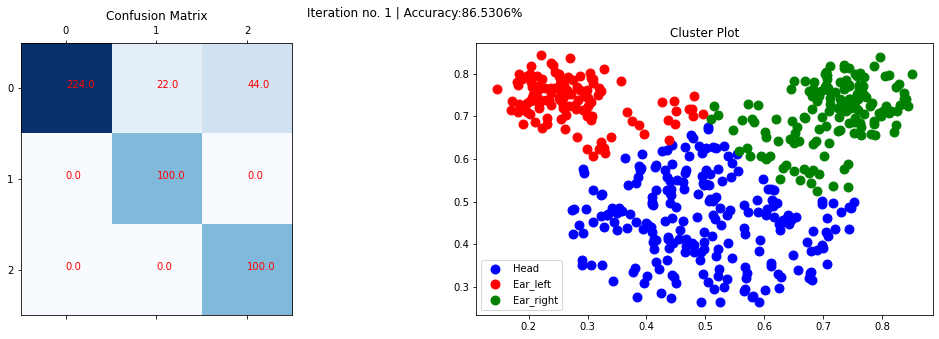

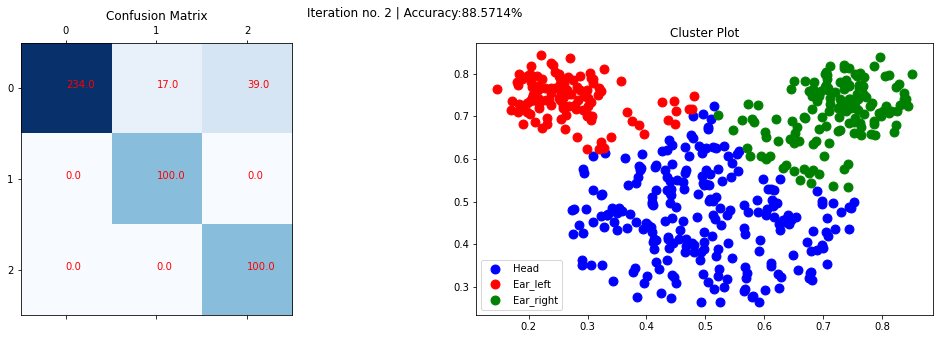

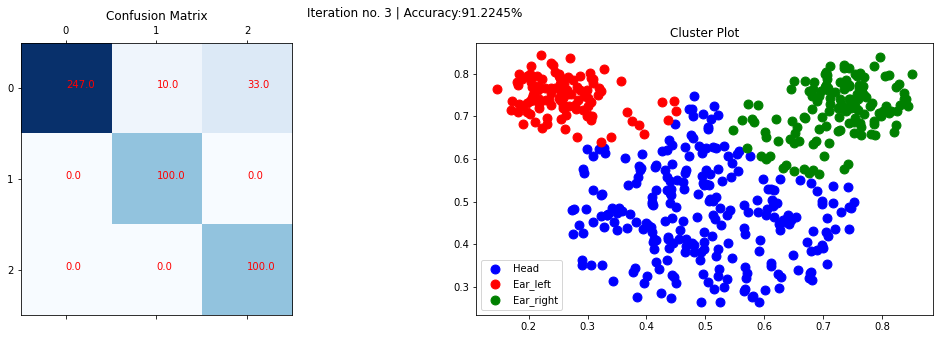

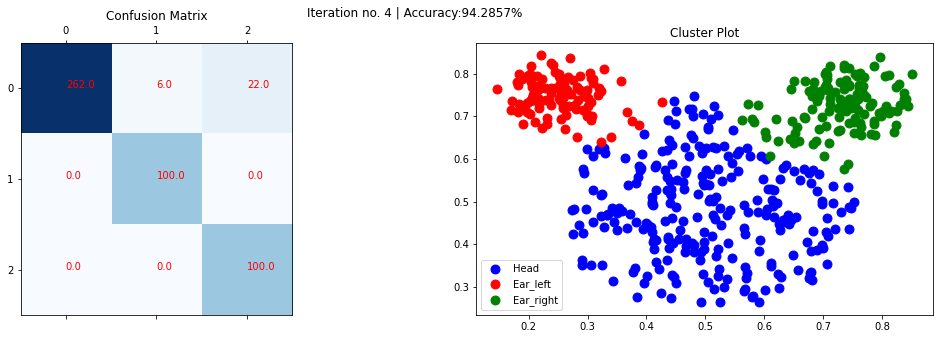

In [26]:
iterations = 0 # to count the iterations
prediction = [] # to store the linkelihoods of the predictions
tolerance = 1e-6
while True:
    ## Calculating the GMM Paramters:
    # calculating the means (size - 3xN)
    for i in range(model.number_clusters):
        model.mean_cluster[i,:] = ClusterMean(model.membership_probabilities[:,i], train_data[:,:])
        print(model.mean_cluster)
    #calculating the variances (size - 3xDxD) where D is the #features
    for j in range(model.number_clusters):
        model.covariance[j,:,:] = ClusterCovariance(train_data, model.mean_cluster[j,:], model.membership_probabilities[:,j])
        print(model.covariance)
        
    # calculating the mixing weights (3x1) for each cluster
    for k in range(model.number_clusters):
        model.weights[k,:] = MixingWeights(model.membership_probabilities[:,k])
        print(model.weights)
    #print(model.mean_cluster)   
    #print(model.covariance)
    #print(model.membership_probabilities)
    pdf = GaussianPDF(train_data, model) # calculates the Gaussian pdf
    
    E_step(pdf, model) # Updating the parameters

    prediction.append(prediction_likelihood(pdf,model.weights))
    
    # Plotting first 4 iterations
    if iterations in range(4):
        classify, _ = NoteClusters(model.membership_probabilities)
        
        fig, ax = plt.subplots(1,2)
        fig.set_size_inches(18,5)
        # calculating the percentage of correctly classified data samples
        ## Plotting the confusion_matrix using sklearn python package
        accuracy = Plot_confusion_matrix(classify, labels, fig.axes[0])
        ax[0].set_title('Confusion Matrix')
        # plotting the clusters after each iteration of the probabilistic Model
        PlotClusters(classify, train_data)
        ax[1].set_title('Cluster Plot')
        fig.suptitle("Iteration no. %d | Accuracy:%.4f" %(iterations+1,accuracy) + "%")
        #fig.savefig(f"plots/q2_gmm_{iterations}_iter.png", dpi=100)
        fig.show()
        
    
    if abs(prediction[iterations] - prediction[iterations-1]) < tolerance and iterations >1:
            break
    
        
    iterations += 1
    
    

In [9]:
def GetClusters(classify, train_data, label):
    # 0-Head, 1-Ear_left, 2-Ear_right
    if label == "head":
        indices_cluster = np.array(np.where(classify == 0)).reshape(-1,1)
    elif label == "ear_left":
        indices_cluster = np.array(np.where(classify == 1)).reshape(-1,1)
    elif label == "ear_right":
        indices_cluster = np.array(np.where(classify == 2)).reshape(-1,1)
    array = np.zeros([indices_cluster.size, 2])
    for i in range(len(indices_cluster)):
        j = indices_cluster[i]
        array[i,:] = train_data[indices_cluster[i], :]
    return array
    
def PlotClusters(classify, train_data):
    # heads
    head = GetClusters(classify, train_data, label="head")
    plt.scatter(head[:,0], head[:,1], color = 'Blue', s=80)
   
    # ear_left
    ear_left = GetClusters(classify, train_data, label="ear_left")
    plt.scatter(ear_left[:,0], ear_left[:,1], color = 'Red', s=80)
    
    # ear_right
    ear_right = GetClusters(classify, train_data, label="ear_right")
    plt.scatter(ear_right[:,0], ear_right[:,1], color = 'Green', s=80)
    plt.legend(["Head", "Ear_left", "Ear_right"])

In [10]:
def Plot_confusion_matrix(predict, actual, ax):
    cm = np.zeros([model.number_clusters, model.number_clusters])
    for k in range(model.number_data_samples):
        cm[actual[k], predict[k]] = cm[actual[k], predict[k]] + 1
        
        #class_labels = ['head', 'ear_left', 'ear_right']
            
    ax.matshow(cm, cmap = 'Blues')
    for i in range(model.number_clusters):
        for j in range(model.number_clusters):
            ax.text(j, i, cm[i,j], fontweight = 500, color="red") 
            
    correct = 0
    for i in range(model.number_clusters):
        for j in range(model.number_clusters):
            if i == j:
                correct += cm[i,j]
    accuracy = (correct/model.number_data_samples)*100
    return accuracy           
        